In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
data = pd.read_csv('winequalityN.csv')
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
# Encoding type of wine
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

print(data.isnull().sum())

# remover linhas que possuem valores faltantes
data.dropna(inplace=True)

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


Antes mesmo da criação e treinamento do modelo, podemos fazer uma análise de informação mútua entre os parâmetros e a classificação

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

x, y = data.drop(columns=['quality']), data['quality']

mi = mutual_info_regression(x, y, random_state=0)
# mi = mutual_info_classif(x, y, random_state=0)
mi_df = pd.Series(mi, index=x.columns).sort_values(ascending=False)
mi_df

,0
alcohol,0.160126
density,0.149433
total sulfur dioxide,0.067258
chlorides,0.066973
residual sugar,0.053237
citric acid,0.051566
volatile acidity,0.043367
free sulfur dioxide,0.040078
sulphates,0.011959
fixed acidity,0.007244


In [ ]:
# Split the into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

x_train, y_train = train_data.drop(columns=['quality']), train_data['quality']
x_val, y_val = val_data.drop(columns=['quality']), val_data['quality']
x_test, y_test = test_data.drop(columns=['quality']), test_data['quality']


# Normalizar as features (exceto a coluna 'quality')
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_val = pd.DataFrame(scaler.transform(x_val), columns=x_val.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


# Convert to PyTorch tensors
X_train, Y_train = torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
train_ds = TensorDataset(X_train, Y_train)

X_val, Y_val = torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)
val_ds = TensorDataset(X_val, Y_val)

X_test, Y_test = torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

n_features = X_val.shape[1]
n_features

12

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=n_features, out_features=1)  # 'n_features' entradas, 1 saída
        nn.init.normal_(self.linear.weight, mean=0, std=0.01)
        nn.init.zeros_(self.linear.bias)

    def forward(self, X):
        return self.linear(X)

def get_loss_fn():
    return nn.L1Loss()
    # return nn.MSELoss()

def get_optimizer(model, lr):
    return optim.SGD(model.parameters(), lr=lr)

In [ ]:
model = LinearRegression()
loss_fn = get_loss_fn()
optimizer = get_optimizer(model, lr=1e-3)

num_epochs = 100

val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_val), Y_val)
        train_loss = loss_fn(model(X_train), Y_train)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
        # val_loss = sum(loss_fn(model(X_val), torch.tensor(y_val))) / len(y_val)
    # print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1034])) that is different to the input size (torch.Size([1034, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, 

<ipython-input-128-fac26c13c011>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


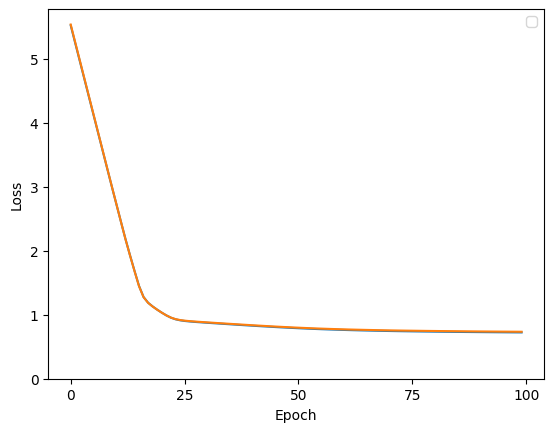

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, num_epochs, 5))
# plt.xticks(np.arange(0, num_epochs))
plt.legend()
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
# plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.show()

In [ ]:
inp_names = list(data.columns)[0:-1]
inp_w_values = model.linear.weight.detach().numpy().reshape((len(inp_names),))
for i in range(len(inp_names)):
  print(f"{inp_names[i]:20}: {inp_w_values[i]:.2f}")

type                : 1.01
fixed acidity       : 1.01
volatile acidity    : 0.89
citric acid         : 0.53
residual sugar      : 0.19
chlorides           : 0.38
free sulfur dioxide : 0.23
total sulfur dioxide: 0.49
density             : 0.57
pH                  : 1.25
sulphates           : 0.64
alcohol             : 0.86
[np.float64(0.7214763307055918), np.float64(0.7005209260759214), np.float64(-0.687432085243386), np.float64(-0.6533735931987216)]


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type,1.00,-0.49,-0.65,0.19,0.35,-0.51,0.47,0.70,-0.39,-0.33,-0.49,0.04,0.12
fixed acidity,-0.49,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10,-0.08
volatile acidity,-0.65,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04,-0.27
citric acid,0.19,0.32,-0.38,1.00,0.14,0.04,0.13,0.19,0.10,-0.33,0.06,-0.01,0.08
residual sugar,0.35,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36,-0.03
chlorides,-0.51,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26,-0.20
free sulfur dioxide,0.47,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18,0.05
total sulfur dioxide,0.70,-0.33,-0.41,0.19,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.26,-0.04
density,-0.39,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69,-0.30
pH,-0.33,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12,0.02


In [ ]:
from scipy.stats import kendalltau

y_pred = model(X_test)
loss = loss_fn(y_pred, Y_test)

# kendalltau é uma medida de correlação que compara a ordem relativa de cada par de pontos, desconsiderando a magnitude
# ou seja, quanto melhor nossa predição manter a ordem dos ranques, maior o valor de tau
tau, _ = kendalltau(y_test, y_pred.detach().numpy())
print(f"Kendall's Tau: {tau:.2f}")
print(f"Loss: {loss:.2f}")


Kendall's Tau: 0.18
Loss: 0.75


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1293])) that is different to the input size (torch.Size([1293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [ ]:
columns_to_drop = [
    # total sulfur dioxide possui correlação grande com 'type' e com 'free sulfur dioxide'
    # podemos então testar criar o modelo sem essa informação
    "total sulfur dioxide"
]

x_test = x_test

# Convert to PyTorch tensors
X_train, Y_train = torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
train_ds = TensorDataset(X_train, Y_train)

X_val, Y_val = torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)
val_ds = TensorDataset(X_val, Y_val)

X_test, Y_test = torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

n_features = X_val.shape[1]
n_features

12

In [ ]:
model = LinearRegression()
loss_fn = get_loss_fn()
optimizer = get_optimizer(model, lr=1e-3)

num_epochs = 100

val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_val), Y_val)
        train_loss = loss_fn(model(X_train), Y_train)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
        # val_loss = sum(loss_fn(model(X_val), torch.tensor(y_val))) / len(y_val)
    # print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1034])) that is different to the input size (torch.Size([1034, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, 

<ipython-input-159-fac26c13c011>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


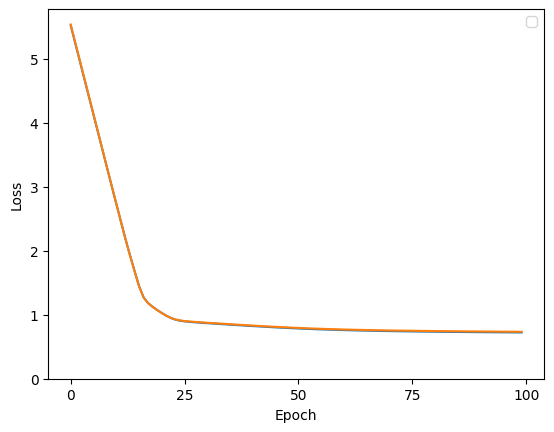

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, num_epochs, 5))
# plt.xticks(np.arange(0, num_epochs))
plt.legend()
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
# plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.show()

In [ ]:
from scipy.stats import kendalltau

y_pred = model(X_test)
loss = loss_fn(y_pred, Y_test)

# kendalltau é uma medida de correlação que compara a ordem relativa de cada par de pontos, desconsiderando a magnitude
# ou seja, quanto melhor nossa predição manter a ordem dos ranques, maior o valor de tau
tau, _ = kendalltau(y_test, y_pred.detach().numpy())
print(f"Kendall's Tau: {tau:.2f}")
print(f"Loss: {loss:.2f}")


Kendall's Tau: 0.18
Loss: 0.75


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1293])) that is different to the input size (torch.Size([1293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
